In [1]:
import sys
sys.path.append(r'lib')
import random
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.signal import find_peaks
from sklearn.decomposition import PCA
from rbf_network import RBF_network
from RBFN import RBFN
from chaos import rossler
np.random.seed(seed=0)
random.seed(1111)

# Generate data

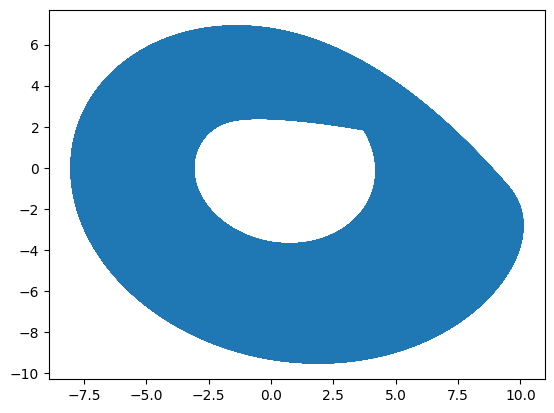

In [2]:
# parameters
a = 0.2
b = 0.2
c_list = [5]
# initial values
x0 = [1, 1, 0]
# setting
dt = 0.01
cut = 100000
T = 1100000

num_time_series = len(c_list)
times = np.arange(0.0, int((T+cut)*dt), dt)

X_list = []
for c in c_list:
    args = (a, b, c)
    X = odeint(rossler, x0, times, args)[cut:,]
    X_list.append(X)
    plt.figure()
    plt.plot(X[:, 0], X[:, 1])

# Data shaping

In [3]:
# Free-runによる再構成アトラクターはtime delayに依存するので
# time delayを適切な値に設定する必要がある
# 訓練・検証用情報
train = 10000
dim = 3
time_delay = 1
var = 0
# rbf network のパラメータ
gamma = 10**-3
N_c = 150

centers = np.zeros((train*len(c_list), dim))
U_test = np.zeros((train*len(c_list), 1))
U_train = []
D_train = []
for i, X in enumerate(X_list):
    X = X[np.arange(0, T, time_delay), var]
    X = np.array([X[i:i-dim-1] for i in range(dim+1)]).T
    
    centers[i*(train):(i+1)*(train), :] = X[:train, :-1]
    U_test[i*(train):(i+1)*(train), :] = X[:train, -1:]
    U_train.append(X[:train, :-1])
    D_train.append(X[:train, -1:])




# My RBFN

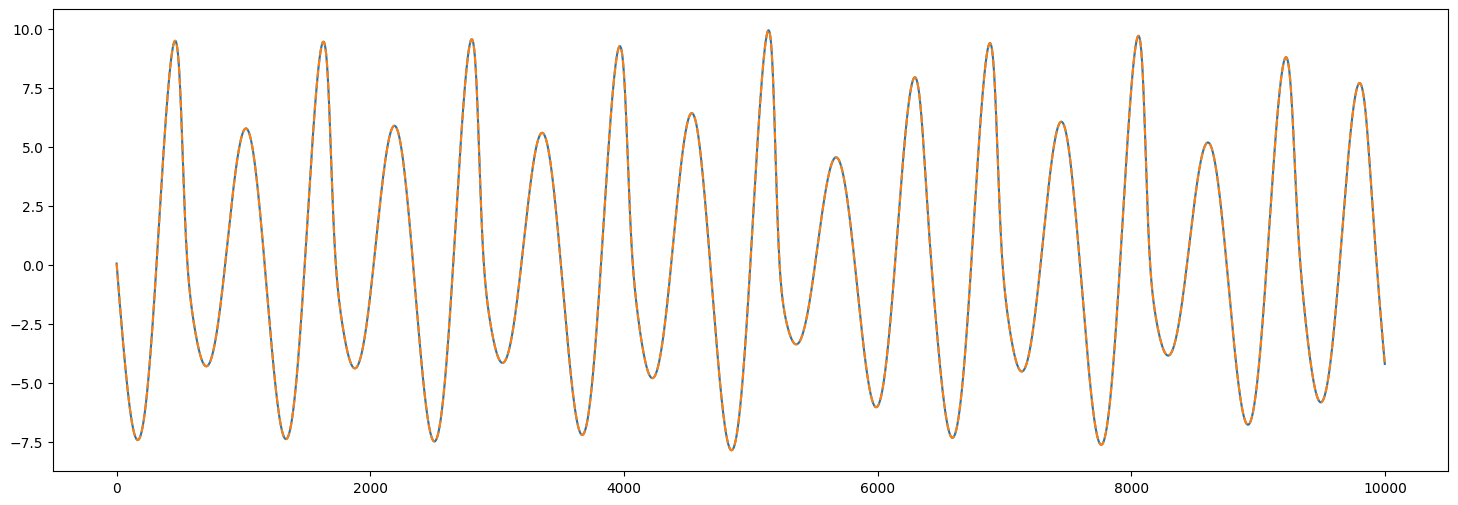

In [4]:
idx = []
for i in range(len(c_list)):
    idx += random.sample(range((train-1)*i, (train-1)*(i+1)), N_c)

rbfn = RBF_network(centers[idx, ], gamma)
W_list = []
K_list = []
for U_train_i, D_train_i in zip(U_train, D_train):
    W, K = rbfn.fit(U_train_i, D_train_i, return_K=True)
    W_list.append(W)
    K_list.append(K)

fig, axes = plt.subplots(1, 1, sharex='all', figsize=(18, 6))
for i, (W, U_train_i, D_train_i) in enumerate(zip(W_list, U_train, D_train)):
    pred = rbfn.predict(U_train_i, W)
    axes.plot(pred[:, 0])
    axes.plot(D_train_i[:, 0], '--')

# Not my RBFN

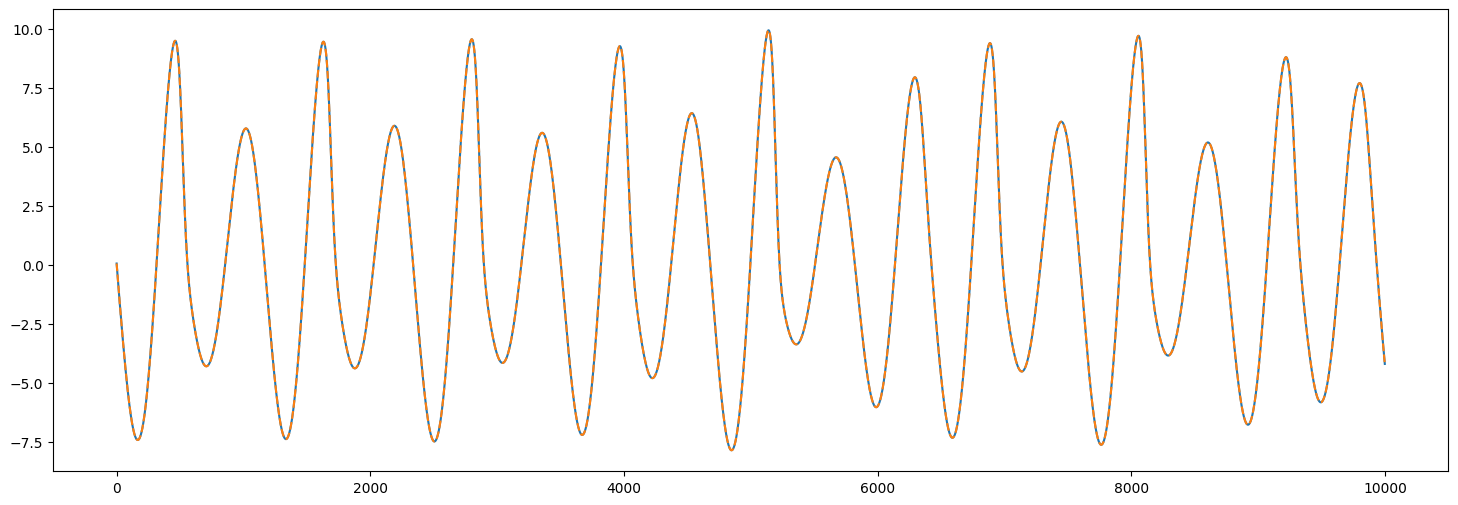

In [5]:
model = RBFN(hidden_shape=150, sigma=gamma)
W, G = model.fit(U_train_i, D_train_i.flatten())
predictions = model.predict(U_train_i)

fig, axes = plt.subplots(1, 1, sharex='all', figsize=(18, 6))
for i, (W, U_train_i, D_train_i) in enumerate(zip(W_list, U_train, D_train)):
    axes.plot(predictions)
    axes.plot(D_train_i[:, 0], '--')

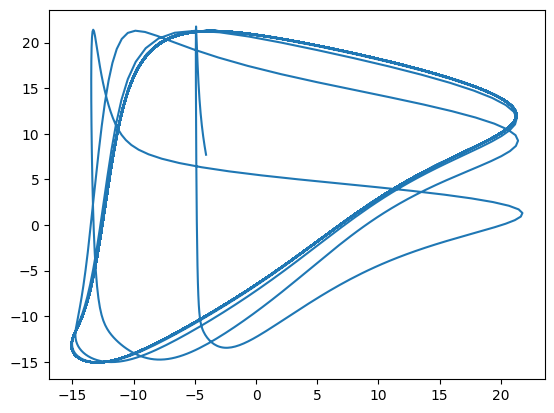

In [6]:
iter = 10000

pred = list(U_test[-dim:].flatten())
for j in range(iter):
    pred.append(model.predict(np.array(pred[-dim:]).reshape(1, -1))[0])
pred = np.array(pred)

plt.plot(pred[:-100], pred[100:])